# **Using pytorch detecting Covid-19 Infected Lungs from Normal Lungs with Chest X-Ray**

In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(torch.__version__)

1.6.0+cu101


In [3]:
import os 
import zipfile

### **Kaggle Preprocessing**

In [4]:
# Upload your own API from Kaggle
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [5]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.0MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=2538a6d6a173f2509a40e08a3fa4da5a54be0e2d27d7186bf1450d470d45b7c6
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

### Importing kaggle Data Train Set

In [7]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database -p "/tmp"

 99% 1.14G/1.15G [00:05<00:00, 195MB/s]
100% 1.15G/1.15G [00:05<00:00, 241MB/s]


In [8]:
local_zip='/tmp/covid19-radiography-database.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [9]:
!mkdir "/tmp/COVID-19 Radiography Database/Xray_train_data"

In [10]:
!mv "/tmp/COVID-19 Radiography Database/COVID-19" "/tmp/COVID-19 Radiography Database/Xray_train_data"

In [11]:
!mv "/tmp/COVID-19 Radiography Database/NORMAL" "/tmp/COVID-19 Radiography Database/Xray_train_data"

In [12]:
!mv "/tmp/COVID-19 Radiography Database/Xray_train_data" "/tmp"

## **Starting Actual work**

In [13]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

### Directing to Train Folder
##### Works similiar as ImageData Generator of Keras

In [14]:
# Defining transform to resize 1024x1024 to 128x128
# To change to Tensor
transform=transforms.Compose([
                              transforms.Resize([64,64]),
                              transforms.ToTensor()
])

In [15]:
dataset=ImageFolder("/tmp/Xray_train_data",transform=transform)

In [16]:
len(dataset)

1560

In [17]:
# Checking For Samples
img0,label0=dataset[0]
print(img0.shape,label0)
img1,label1=dataset[1200]
print(img1.shape,label1)
print("*"*60)
print(dataset.classes)#list out all the classes

torch.Size([3, 64, 64]) 0
torch.Size([3, 64, 64]) 1
************************************************************
['COVID-19', 'NORMAL']


label--> NORMAL


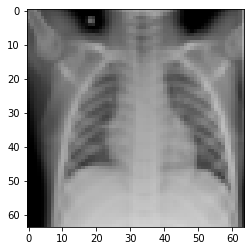

In [18]:
def show(img,label):
  print("label-->",dataset.classes[label])
  plt.imshow(img.permute(1,2,0))

show(*dataset[1441])
# 0-->Covid-19;1-->Normal

### Splitting Validation Set from Training Set

In [19]:
def split_train_val(tot_img,val_percentage=0.2,rnd=23):
  number_of_val=int(tot_img*val_percentage)
  np.random.seed(rnd)
  indexs=np.random.permutation(tot_img)
  return indexs[number_of_val:],indexs[:number_of_val]

randomness=12
val_per=0.5
train_indices,validation_indices=split_train_val(len(dataset),val_per,randomness)
print(validation_indices[:5])

[ 850  746 1175  343  793]


In [20]:
from torch.utils.data.sampler import SubsetRandomSampler #samples randomly from given indices
from torch.utils.data.dataloader import DataLoader # loads the data from sampler

In [21]:
batch_size=32
# Training Part
train_sampler=SubsetRandomSampler(train_indices)
train_ds=DataLoader(dataset,batch_size,sampler=train_sampler)

# Validation Part
val_sampler=SubsetRandomSampler(validation_indices)
val_ds=DataLoader(dataset,batch_size,sampler=val_sampler)

### Optional: To see one batch of image

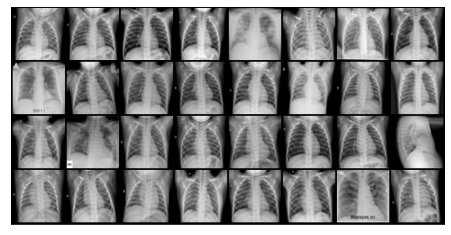

In [22]:
from torchvision.utils import make_grid
def one_batch(data_load):
  for imgs,lbls in data_load:
    fig,ax=plt.subplots(figsize=(8,4))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(imgs,8).permute(1,2,0))
    break
one_batch(train_ds)

### **Did not Use GPU because computation is not expensive**

## **Applying CNN**

In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
# 1st layer of Conv2d
# 1st Argument is number of color channel for RGB=3, for BW=1
# 2nd Argument if number of filters, 3rd is filter size
# how to calculate its output directly to Linear Unit
# image=3x64x64-->64-3(filter_size)+1=62. So, output is 62x62xnumber of filter
# then 62x62xnum_of_filter-->maxpool(2,2)-->62/2=31-->32*31*31
# for same layer number of filter of output is input of new channel
# for conv to linear layer the above calculation is reqd.

model=nn.Sequential(
        nn.Conv2d(3,8,3), 
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Flatten(),
        nn.Linear(8*31*31,2)

)

In [25]:
model[0].weight.shape

torch.Size([8, 3, 3, 3])

In [26]:
print(model)

Sequential(
  (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten()
  (4): Linear(in_features=7688, out_features=2, bias=True)
)


In [27]:
# Define loss and optimizer
import torch.optim as optim
loss_type = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [28]:
for epoch in range(15):  
# loop over the dataset multiple times

    for i, data in enumerate(train_ds):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = loss_type(outputs, labels)
        loss.backward()
        optimizer.step()

print('Finished Training')

Finished Training


In [45]:
right = 0
total = 0
with torch.no_grad():
    for data in val_ds:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        right += (predicted == labels).sum().item()

print('Accuracy on the validation images: %d %%' % (
    100 * right / total))

Accuracy on the validation images: 97 %


## **Importing Test data and testing on it**
#### This is completely from different source from train,val data

In [30]:
!kaggle datasets download -d fusicfenta/chest-xray-for-covid19-detection -p "/tmp"

 90% 158M/176M [00:00<00:00, 289MB/s]
100% 176M/176M [00:00<00:00, 321MB/s]


In [31]:
local_zip='/tmp/chest-xray-for-covid19-detection.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall("/tmp")
zip_ref.close()

In [32]:
!ls "/tmp/Dataset"

Prediction  Train  Val


In [33]:
!mkdir "/tmp/Xray_val_data"

In [34]:
!mv "/tmp/Dataset/Train/Covid" "/tmp/Xray_val_data"

In [35]:
!mv "/tmp/Dataset/Train/Normal" "/tmp/Xray_val_data"

In [36]:
!ls "/tmp/Xray_val_data"

Covid  Normal


In [37]:
transform=transforms.Compose([
                              transforms.Resize([64,64]),
                              transforms.ToTensor()
])
test_dataset=ImageFolder("/tmp/Xray_val_data",transform=transform)

In [38]:
len(test_dataset)

288

In [39]:
# Checking For Samples
img0,label0=test_dataset[0]
print(img0.shape,label0)
img1,label1=test_dataset[150]
print(img1.shape,label1)
print("*"*60)
print(test_dataset.classes)#list out all the classes

torch.Size([3, 64, 64]) 0
torch.Size([3, 64, 64]) 1
************************************************************
['Covid', 'Normal']


In [40]:
def split_train_val(tot_img,val_percentage=0.2,rnd=23):
  number_of_val=int(tot_img*val_percentage)
  np.random.seed(rnd)
  indexs=np.random.permutation(tot_img)
  return indexs[number_of_val:],indexs[:number_of_val]

randomness=12
test_per=0.5
test1_indices,test2_indices=split_train_val(len(test_dataset),test_per,randomness)
print(test2_indices[:5])

[237 256 133  11  94]


In [41]:
batch_size=32
# Training Part
test1_sampler=SubsetRandomSampler(test1_indices)
test1_ds=DataLoader(test_dataset,batch_size,sampler=test1_sampler)

test2_sampler=SubsetRandomSampler(test2_indices)
test2_ds=DataLoader(test_dataset,batch_size,sampler=test2_sampler)

In [46]:
right = 0
total = 0
with torch.no_grad():
    for data in test1_ds:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        right += (predicted == labels).sum().item()

print('Accuracy on the Test images: %d %%' % (
    100 * right / total))

Accuracy on the Test images: 93 %
